## Exploring the Olympics dataset

Have you ever had a sports clash turn into a data analytics project? Well, this is what happened to me and a close group of friends during one casual conversation about sports!!

We decided to do some number crunching on 120 years of olympics to see which are the best performing countries at the olympics and what makes them great!

We got the [olympics dataset](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) from kaggle, and decided to merge it with the country wise [gdp](https://www.kaggle.com/resulcaliskan/countries-gdps) and [population data](https://www.kaggle.com/centurion1986/countries-population).

With our weapons ready, its time to see who's BOSS!

In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in the data set
olympics = pd.read_csv('./Data/athlete_events.csv')
print olympics.head()

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

### Data exploration and Basic Hygiene

#### 1) Missing Values

In [3]:
print olympics.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


We find that height, weight and Age have a lot of missing values. Medals have a NaN in about 2,31,333 rows. These can be explained since not all participating athletes would win medals.

Let's replace these missing values by 'Did not win' or 'DNW'

In [4]:
olympics['Medal'].fillna('DNW', inplace = True)

In [5]:
# As expected the NaNs in the 'Medal' column disappear!
print olympics.isnull().sum()

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


#### 2) NOC - National Olympic Committee. 
These are responsible for organizing their people's participation in the Olympics.
Are all NOCs linked to a unique team? We can find this out by taking a unique subset of just the NOC and team columns and taking a value count.

In [6]:
print olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head()

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: NOC, dtype: int64


Hmm, This looks interesting. So NOC code 'FRA' is associated with 160 teams? That sounds prepostorous! Let's do a groupby and verify this.

In [7]:
olympics_NOC_Team = olympics.groupby(['NOC', 'Team'])[['Medal']].agg('count').reset_index()

print len(olympics_NOC_Team.loc[olympics_NOC_Team['NOC'] == 'FRA', :])

160


So this is true! Okay let's use a master of NOC to country mapping to correct this.

In [8]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('./Data/noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

print noc_country.head()

   NOC      Country
0  AFG  Afghanistan
1  AHO      Curacao
2  ALB      Albania
3  ALG      Algeria
4  AND      Andorra


We now need to merge the original dataset with the NOC master using the NOC code as the primary key. This has to be a left join since we want all participating countries to remain in the data even if their NOC-Country is not found in the master. We can easily correct those manually.

In [9]:
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

print olympics_merge.head()

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal      Country  
0       Basketball Men's Basketball   DNW        China  
1      Judo Men's Extra-Lightweight   DNW   

Do we having NOCs in olympics that are not found in the NOC master data?

In [10]:
# Do we have NOCs that didnt have a matching country in the master?
print olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

        NOC                      Team
578     SGP                 Singapore
6267    ROT  Refugee Olympic Athletes
44376   SGP              June Climene
61080   UNK                   Unknown
64674   TUV                    Tuvalu
80986   SGP                   Rika II
108582  SGP               Singapore-2
235895  SGP               Singapore-1


So, we see that SGP, ROT, UNK and TUV from the olympics data find no match in the NOC master data. Looking at their 'Team' names we can manually insert the correct values into the olympics data.

Let's put these values in Country - <br>
    1. SGP - Singapore
    2. ROT - Refugee Olympic Athletes
    3. UNK - Unknown
    4. TUV - Tuvalu

In [11]:
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

Checking again for mapping of NOC to team we find that each is mapped to a single value! Nice!

In [12]:
print olympics_merge.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head()

PNG    1
BUL    1
UGA    1
TKM    1
SCG    1
Name: NOC, dtype: int64


### Merge GDP data

In [13]:
# Glance at the data.
w_gdp = pd.read_csv('.\Data\world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

print w_gdp.head()

     Country Name Country Code  Year           GDP
0     Afghanistan          AFG  1960  5.377778e+08
1         Albania          ALB  1960           NaN
2         Algeria          DZA  1960  2.723649e+09
3  American Samoa          ASM  1960           NaN
4         Andorra          AND  1960           NaN


Looking at the data we find that 'Indicator Name' and 'Indicator Code' have only one value in the entire column. We can therefore safely remove these columns from the dataset.

Before we actually merge, lets check if NOCs in the olympics data match with those in the Country Code.

In [14]:
print len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108


So, 108 NOCs in the olympics dataset dont have representation in the gdp data country codes. Is the name of the country a better way to merge?

In [15]:
print len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

5


Aha! only 5! What countries are these? So maybe what I can do is, add a country code for each Team in the olympics dataset to help ease things.

In [16]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

### Merge Population Data

In [17]:
# Read in the population data
w_pop = pd.read_csv('.\Data\world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

print w_pop.head()

       Country Country Code  Year  Population
0        Aruba          ABW  1960     54211.0
1  Afghanistan          AFG  1960   8996351.0
2       Angola          AGO  1960   5643182.0
3      Albania          ALB  1960   1608800.0
4      Andorra          AND  1960     13411.0


Before we merge, lets check the matches between Country code in olympics_merge_gdp and country code in w_pop.

In [18]:
print list(set(olympics_merge_gdp['Country Code']) - set(w_pop['Country Code'])) 

[nan, 'SSD', 'ERI']


In [19]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

print olympics_complete.head()

   ID                      Name Sex   Age  Height  Weight  NOC        Games  \
0   1                 A Dijiang   M  24.0   180.0    80.0  CHN  1992 Summer   
1   2                  A Lamusi   M  23.0   170.0    60.0  CHN  2012 Summer   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN  DEN  1920 Summer   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  DEN  1900 Summer   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0  NED  1988 Winter   

   Year  Season       City          Sport                             Event  \
0  1992  Summer  Barcelona     Basketball       Basketball Men's Basketball   
1  2012  Summer     London           Judo      Judo Men's Extra-Lightweight   
2  1920  Summer  Antwerpen       Football           Football Men's Football   
3  1900  Summer      Paris     Tug-Of-War       Tug-Of-War Men's Tug-Of-War   
4  1988  Winter    Calgary  Speed Skating  Speed Skating Women's 500 metres   

  Medal         Team Country Code           GDP   

There are a lot of missing values in the data, this is to be attributed to the countries not found in the GDP and population masters and also the fact that Population and GDP are only for 1961 onwards while Olympics data is from 1896.

In [20]:
print olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age              9474
Height          60171
Weight          62875
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code     1245
GDP             86777
Population      64972
dtype: int64


In [21]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()

### Data Visualization

### Who has the most medals across all editions of the olympics?
Medal tally is the sum of all medals won.

Let's create a column that captures whether or not a medal was won! It would be 1 if Medal column says Gold, Silver or Bronze and 0 otherwise.

In [22]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

Who are the greatest olympics playing nations of all time? Lets make a pivot table to find out!

In [23]:
# Medal Tally.
medal_tally = olympics_complete_subset.groupby(['Year','Team'])['Medal_Won'].agg('sum').reset_index()

print pd.pivot_table(medal_tally,
              index = 'Team',
              columns = 'Year',
              values = 'Medal_Won',
              aggfunc = 'sum',
              margins = True).sort_values('All', ascending = False)[1:5]

Year        1964   1968   1972   1976   1980   1984   1988   1992   1996  \
Team                                                                       
USA        169.0  166.0  171.0  164.0    NaN  352.0  207.0  224.0  259.0   
Russia     174.0  192.0  214.0  286.0  442.0    NaN  300.0  220.0  115.0   
Germany    116.0  103.0  253.0  273.0  264.0  158.0  296.0  198.0  124.0   
Australia   44.0   51.0   20.0   23.0   13.0   52.0   35.0   57.0  132.0   

Year        2000   2004   2008   2012   2016   All  
Team                                                
USA        242.0  263.0  317.0  248.0  264.0  3046  
Russia     187.0  189.0  142.0  140.0  115.0  2716  
Germany    118.0  149.0   99.0   94.0  159.0  2404  
Australia  183.0  157.0  149.0  114.0   82.0  1112  


USA, Russia, Germany and Australia are the best countries of all time when it comes to medal tallies. What do the yearwise medal tallies look like?

Text(0.5,1,'Olympic Performance Comparison')

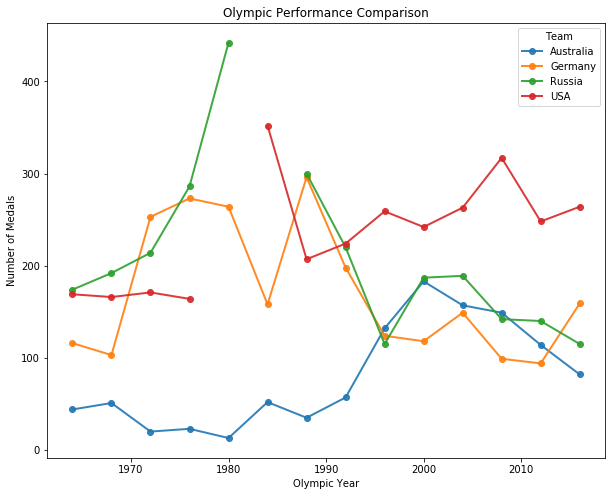

In [24]:
req_countries = ['USA', 'Russia', 'Germany', 'Australia']
row_mask_1 = medal_tally['Team'].map(lambda x: x in req_countries)

# Making a pivot table with the medal tallies
year_team_medals = pd.pivot_table(medal_tally.loc[row_mask_1, :],
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won',
                                  aggfunc = 'sum')

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance Comparison')

**Interesting Insight 1**: The blank value at 1980 for USA is not a data error! In 1980, the United States led a boycott of the Summer Olympic Games in Moscow to protest the late 1979 Soviet invasion of Afghanistan. In total, 65 nations refused to participate in the games, whereas 80 countries sent athletes to compete, India being one of those.

**Interesting Insight 2**:The missing point at 1984 for Russia is no error either! The boycott of the 1984 Summer Olympics in Los Angeles followed four years after the U.S.-led boycott of the 1980 Summer Olympics in Moscow. The boycott involved 14 Eastern Bloc countries and allies, led by the Soviet Union, which initiated the boycott on May 8, 1984.

Lets plot a breakup of medal tally by the medal type - Gold, Silver, Bronze

Text(0,0.5,'Country')

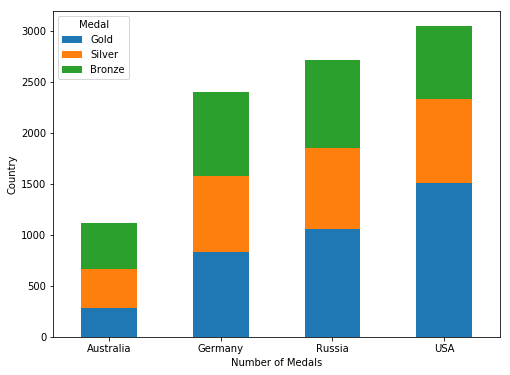

In [25]:
row_mask_2 = olympics_complete_subset['Team'].map(lambda x: x in req_countries)

medal_tally_specific = pd.pivot_table(olympics_complete_subset.loc[row_mask_2,:],
                                     index = 'Team',
                                     columns = 'Medal',
                                      values = 'Medal_Won',
                                     aggfunc = 'sum').drop('DNW', axis = 1)
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Number of Medals')
ylabel('Country')

Surprisingly, countries are also in order of gold medal tallies!

### What sports are these countries best at? 
Those would be sports that they have got the most gold medals for across the years.

In [26]:
best_team_sports = pd.pivot_table(olympics_complete_subset[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won',
                                  aggfunc = 'sum',
                                  fill_value = 0).drop('DNW', axis = 1).sort_values(['Team', 'Gold'], 
                                                                                    ascending = [True, False]).reset_index()
print best_team_sports.groupby('Team').head(5)

Medal       Team                                            Event  Bronze  \
0      Australia                            Hockey Women's Hockey       0   
1      Australia  Swimming Women's 4 x 100 metres Freestyle Relay       5   
2      Australia                              Hockey Men's Hockey      79   
3      Australia     Swimming Women's 4 x 100 metres Medley Relay       0   
4      Australia                    Water Polo Women's Water Polo      26   
347      Germany                              Hockey Men's Hockey      32   
348      Germany                        Rowing Men's Coxed Eights      18   
349      Germany               Equestrianism Mixed Dressage, Team       0   
350      Germany                    Rowing Men's Quadruple Sculls       8   
351      Germany                      Rowing Women's Coxed Eights       9   
699       Russia                          Handball Men's Handball      14   
700       Russia                      Volleyball Men's Volleyball      36   

Okay, so we observe that team sports are coming at the top the most times. This would be because when a team wins gold, the records would have details of each player that won and the count would multiply times the team members.
We need to correct for this to get the actual sports that these countries are good at.

#### If a team wins more than one gold medal for an event in an edition of the olympics, then that event is a team event.

In [27]:
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

So, what events are team events? The list below gives names of each event where in a single edition multiple golds were given. Going through the list, however, we found that some events have crept in which are not usually team events. Some examples include - <br>
    1. Gymnastics Women's Balance Beam
    2. Gymnastics Men's Horizontal Bar
    3. Swimming Women's 100 metres Freestyle
    4. Swimming Men's 50 metres Freestyle

Upon analysis, I found that these are actually single events but because two athletes had the same score/time, both were awarded the gold medal. We need to remove these events from the list of team sports

In [28]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

The next thing we need to do is add a column in the dataset that correctly identifies whether the event in the given record is a team event.

In [29]:
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

medal_mask = olympics_complete_subset['Medal_Won'] == 1

olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + olympics_complete_subset['Team_Event']

print olympics_complete_subset.head(2)

   index  ID       Name Sex   Age  Height  Weight  NOC        Games  Year  \
0      0   1  A Dijiang   M  24.0   180.0    80.0  CHN  1992 Summer  1992   
1      1   2   A Lamusi   M  23.0   170.0    60.0  CHN  2012 Summer  2012   

        ...                               Event Medal   Team Country Code  \
0       ...         Basketball Men's Basketball   DNW  China          CHN   
1       ...        Judo Men's Extra-Lightweight   DNW  China          CHN   

            GDP    Population Medal_Won  Team_Event  Single_Event  \
0  4.269160e+11  1.164970e+09         0           0             0   
1  8.560550e+12  1.350695e+09         0           0             0   

   Event_Category  
0               0  
1               0  

[2 rows x 23 columns]


Now, its time to calculate medal tally agnostic of the team size - one gold means one gold for an event. To do this we divide the number of medals by the count of winning team members. How do we get the team members? Sum of team_event column should do that for us!

In [30]:
medal_tally_agnostic = olympics_complete_subset[row_mask_2].\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

# To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.
best_team_sports = pd.pivot_table(medal_tally_agnostic,
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

print best_team_sports.groupby('Team').head(5)

Medal       Team                                          Event  Bronze  DNW  \
0      Australia          Swimming Men's 1,500 metres Freestyle       4    0   
1      Australia            Swimming Men's 400 metres Freestyle       3    0   
2      Australia      Equestrianism Mixed Three-Day Event, Team       3    0   
3      Australia                          Hockey Women's Hockey       0    0   
4      Australia                Sailing Men's Two Person Dinghy       0    0   
347      Germany             Equestrianism Mixed Dressage, Team       0    0   
348      Germany     Canoeing Women's Kayak Doubles, 500 metres       2    0   
349      Germany                  Rowing Men's Quadruple Sculls       2    0   
350      Germany                Rowing Women's Quadruple Sculls       1    0   
351      Germany                   Athletics Men's Discus Throw       2    0   
699       Russia         Wrestling Men's Heavyweight, Freestyle       0    0   
700       Russia                      Fe

Much Better! This now presents a better picture of the sports competencies of these nations! What we have done is essentially consider one win in a team event in one edition mean one medal. So what the above table shows us is how many times does a country win repeatedly at an event! Note that Basketball was in the top for USA even before and it is still at number 5!

### Next we look at the size of the olympic contingent that these countries send to the Olympics!

How do the contingents for the various countries look like?

In [31]:
# take for each year, the team, name of the athlete and gender of the athlete and drop duplicates. These are values
# where the same athlete is taking part in more than one sport.
year_team_gender = olympics_complete_subset.loc[row_mask_2, ['Year','Team', 'Name', 'Sex']].drop_duplicates()

In [32]:
# Create a pivot table to count gender wise representation of each team in each year
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

In [35]:
# Separate country wise data

aus_data = year_team_gender_count[year_team_gender_count['Team'] == "Australia"]
aus_data.set_index('Year', inplace = True)

ger_data = year_team_gender_count[year_team_gender_count['Team'] == "Germany"]
ger_data.set_index('Year', inplace = True)

rus_data = year_team_gender_count[year_team_gender_count['Team'] == "Russia"]
rus_data.set_index('Year', inplace = True)

usa_data = year_team_gender_count[year_team_gender_count['Team'] == "USA"]
usa_data.set_index('Year', inplace = True)

Plotting the contingent size with male and female athletes respectively for each country.

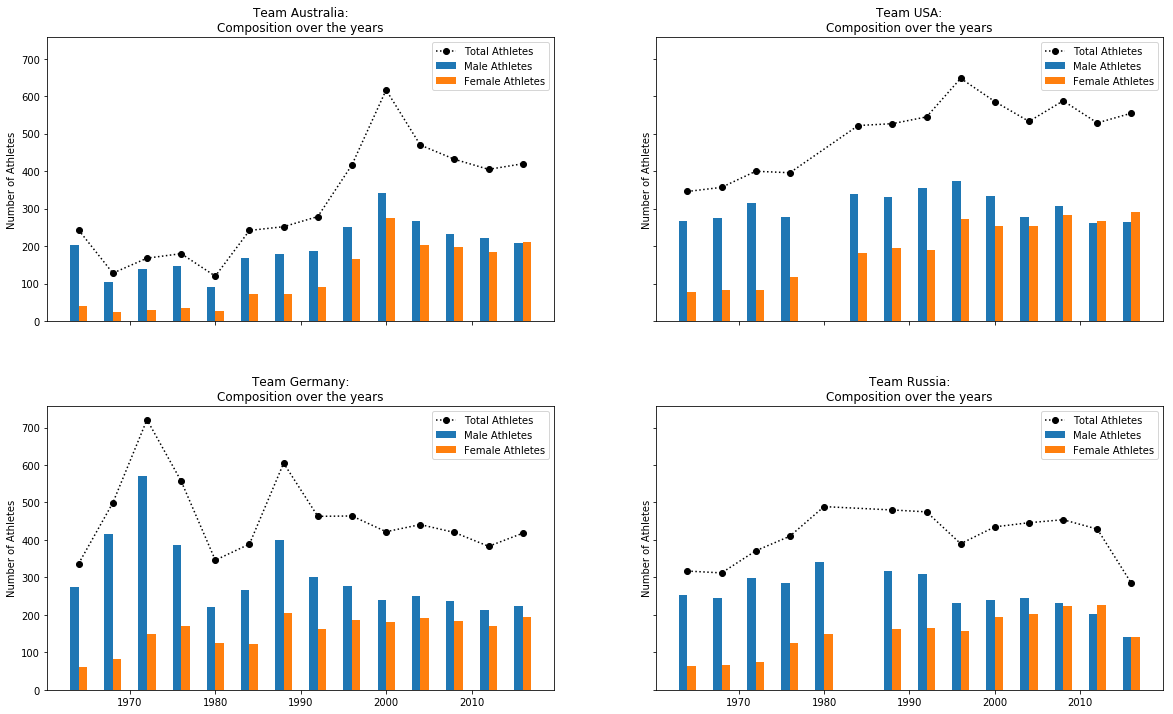

In [37]:
# Plot the values of male, female and total athletes using bar charts and the line charts.
fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2, ncols = 2, figsize = (20, 12), sharey = True, sharex = True)
fig.subplots_adjust(hspace = 0.3)

# Plot team Australia's contingent size
ax1.bar(aus_data.index.values, aus_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax1.bar(aus_data.index.values, aus_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax1.plot(aus_data.index.values, aus_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax1.set_title('Team Australia:\nComposition over the years')
ax1.set_ylabel('Number of Athletes')
ax1.legend(loc = 'best')

# Plot team USA's contingent size
ax2.bar(usa_data.index.values, usa_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax2.bar(usa_data.index.values, usa_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax2.plot(usa_data.index.values, usa_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax2.set_title('Team USA:\nComposition over the years')
ax2.set_ylabel('Number of Athletes')
ax2.legend(loc = 'best')

# Plot team Germany's contingent size
ax3.bar(ger_data.index.values, ger_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax3.bar(ger_data.index.values, ger_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax3.plot(ger_data.index.values, ger_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes', 
         marker = 'o')
ax3.set_title('Team Germany:\nComposition over the years')
ax3.set_ylabel('Number of Athletes')
ax3.legend(loc = 'best')

# Plot team Russia's contingent size
ax4.bar(rus_data.index.values, rus_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax4.bar(rus_data.index.values, rus_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax4.plot(rus_data.index.values, rus_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax4.set_title('Team Russia:\nComposition over the years')
ax4.set_ylabel('Number of Athletes')
ax4.legend(loc = 'best')

show()

### Does the size of the contingent relate with the number of medals?

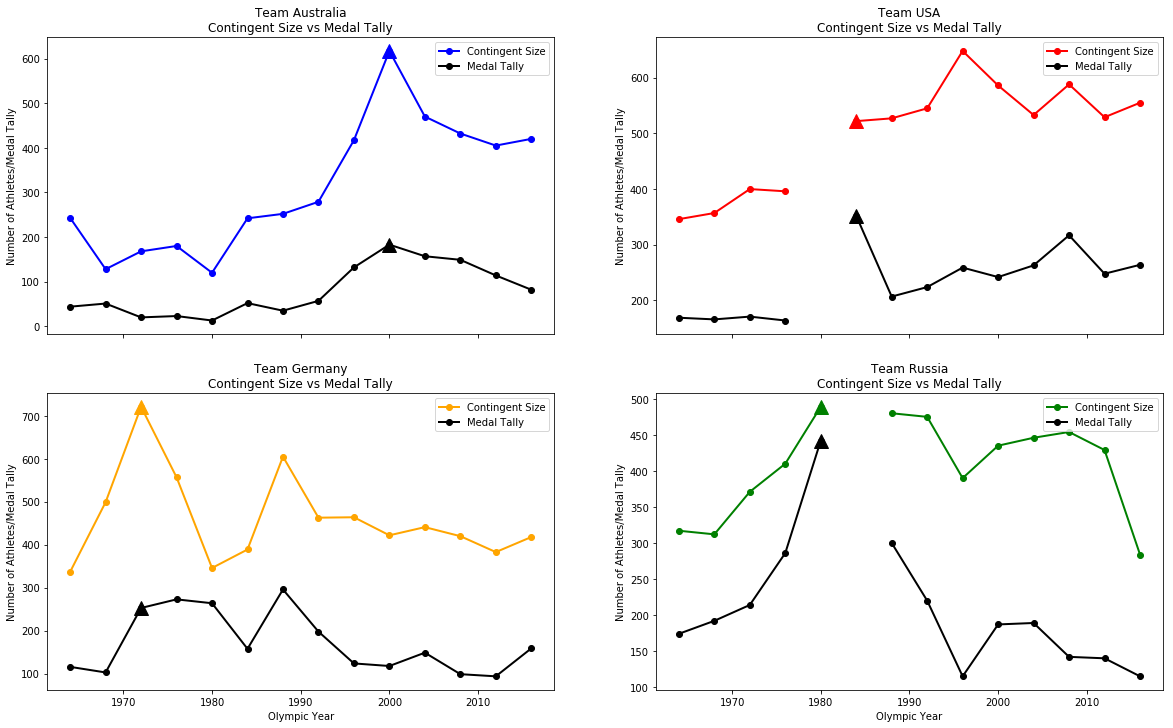

In [38]:
# Get year wise team wise athletes.
year_team_athelete = olympics_complete_subset.loc[row_mask_2, ['Year','Team', 'Name']].drop_duplicates()

# sum these up to get total contingent size.
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2,
                                         ncols = 2,
                                         sharex = True,
                                        figsize = (20,12))

# Plot australia's medal tally and contingent size
contingent_size['Australia'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'blue', 
                                  label = 'Contingent Size')
year_team_medals['Australia'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                  label = 'Medal Tally')
ax1.plot(2000, contingent_size.loc[2000, 'Australia'], marker = '^', color = 'blue', ms = 14)
ax1.plot(2000, year_team_medals.loc[2000, 'Australia'], marker = '^', color = 'black', ms = 14)
ax1.set_xlabel('Olympic Year')
ax1.set_ylabel('Number of Athletes/Medal Tally')
ax1.set_title('Team Australia\nContingent Size vs Medal Tally')
ax1.legend(loc = 'best')

# Plot USA's medal tally and contingent size
contingent_size['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'red',
                           label = 'Contingent Size')
year_team_medals['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = 'Medal Tally')
ax2.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'red', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'black', ms = 14)
ax2.set_xlabel('Olympic Year')
ax2.set_ylabel('Number of Athletes/Medal Tally')
ax2.set_title('Team USA\nContingent Size vs Medal Tally')
ax2.legend(loc = 'best')

# Plot Germany's medal tally and contingent size
contingent_size['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'orange',
                               label = 'Contingent Size')
year_team_medals['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                label = 'Medal Tally')
ax3.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'black', ms = 14)
ax3.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'orange', ms = 14)
ax3.set_xlabel('Olympic Year')
ax3.set_ylabel('Number of Athletes/Medal Tally')
ax3.set_title('Team Germany\nContingent Size vs Medal Tally')
ax3.legend(loc = 'best')

# Plot Russia's medal tally and contingent size
contingent_size['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'green',
                              label = 'Contingent Size')
year_team_medals['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                               label = 'Medal Tally')
ax4.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'green', ms = 14)
ax4.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'black', ms = 14)
ax4.set_xlabel('Olympic Year')
ax4.set_ylabel('Number of Athletes/Medal Tally')
ax4.set_title('Team Russia\nContingent Size vs Medal Tally')
ax4.legend(loc = 'best')

show()

It is interesting to see that for each of these countries, a point of peak in the contingent size translates directly to a peak in the medal tally! These have been marked as large triangles on the plots

### Are there some commonalities between the countries?
Are there common things they are all good at?

In [39]:
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(10).reset_index()

pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,Australia,Germany,Russia,USA,All
Sport,,,,,
Swimming,5,0,0,5,10
Athletics,1,1,2,4,8
Canoeing,0,4,0,0,4
Wrestling,0,0,4,0,4
Rowing,0,3,0,0,3
Cycling,1,1,0,0,2
Equestrianism,1,1,0,0,2
Basketball,0,0,0,1,1
Fencing,0,0,1,0,1


#### Interesting Insights 3:
1. One thing all nations have in their top 10 sports is athletics!
2. Australia and US have a penchant for swimming events!
3. Germany is solid in rowing and canoeing!
4. Russia loves to wrestle!

## Well, this was exciting! 

#### We learnt that -
1. Australia, Germany, Russia and USA are medal tally leaders in the olympics if we count beginning in 1964. They have all sent varying number of athletes into events over time and have fared better with higher contingent sizes. 
2. Women, who were not a very large part of the Olympics contingents for these countries now enjoy equal representation in the olympics teams. 
3. 1980 and 1984 were weird years, with USA not participating in 1980 due to Russia invading Afghanistan and then Russia retaliating in 1984 by not participating and starting the friendship games.
4. The current method of medal tallies is highly skewed by the way we count medals in team events - if a hockey team wins gold, it is counted as 16 gold medals! We also found a nifty way to tackle this problem to find the most successful sports events per country.
5. This led us to the finding that while Australia and USA love swimming, Russia likes to wrestle and mostly all of them like athletics.